# Bayesian Logistic Regression for Breast Cancer Data Set
The setting for this experiment is a reconstruction of an experiment in the paper *Parallel MCMC with Generalized Elliptical Slice Sampling* (Nishihara et al. 2014). The likelihood is obtained by the usual logistic regression model for the 30-dimensional *breast cancer Wisconsin diagnostic data set*, as can be retrieved from [Kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data), normalized so that each feature has sample mean zero and sample variance one. 

Denote the data set as $(a^{(i)},b^{(i)})_{i=1,...,n_{\text{data}}} \subset \mathbb{R}^d \times \{-1,1\}$, where $d = 31$, $n_{\text{data}} = 569$ and where have padded the data by $a^{(i)}_d := 1 \; \forall i$ to enable an intercept.
Our prior is the mean-zero Gaussian $\mathcal{N}_d(0, \sigma^2 I_d)$ with $\sigma^2 = 100$. The likelihood is obtained by the usual logistic regression model. Our target density, the (unnormalized) posterior density, is therefore given by
$$
\varrho(x)
= \mathcal{N}_d(x; 0, \sigma^2 I_d) \prod_{i=1}^{n_{\text{data}}} \frac{1}{1 + \exp(-b^{(i)} \langle a^{(i)}, x \rangle)} , 
\quad x \in \mathbb{R}^d .
$$

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
from generalized_elliptical_slice_sampling import two_group_gess
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/BLR_breast_cancer_"

### Retrieve and Prepare the Data, do Feature Engineering, Construct the Target Density

In [4]:
# load data set from file
data = pd.read_csv("../data/breast_cancer_wisconsin_diagnostic.csv")
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [5]:
# retrieve features, normalize them to mean zero and unit variance, append a unit feature to enable intercept
n_data = data.shape[0]
features = data.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1)
a = np.hstack([((features - features.mean()) / features.std()).to_numpy(), np.ones((n_data,1))])

In [6]:
# retrieve labels (B = benign, M = malignant), map them to +-1
labels = data['diagnosis'].to_numpy()
b = np.array(labels == 'M', dtype=int) - np.array(labels == 'B', dtype=int)

In [7]:
# set/retrieve some general parameters
d = a.shape[1]
sig_sq = 100 # prior variance

In [8]:
# construct posterior
def log_density(x):
    return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))

### Run the Samplers

In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

Note: If either PATT or GESS is run before HRUSS and AdaRWM, it can break the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [9]:
n_chains = 10 # number of parallel chains permitted to each sampler (except GESS)
n_its = int(1e5) # total number of iterations per chain, per sampler (except AdaRWM, GESS)
x_0s = rnd.normal(size=(n_chains,d)) # suggested initial states

#### Hit-and-Run Uniform Slice Sampling

In [10]:
w_hruss = 1.0

In [11]:
samples_hruss, tde_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3622.75it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis
Note: We grant AdaRWM significantly more iterations than PATT-GPSS and HRUSS because it has a much lower computational cost per iteration by virtue of only using one TDE per iteration.

In [12]:
n_its_rwm = 5 * n_its

In [13]:
samples_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [01:00<00:00, 8207.52it/s]


Processing returns and terminating...


In [14]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

#### PATT Elliptical Slice Sampling

In [15]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [16]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [17]:
samples_ess = np.concatenate([ret_dic['burn-in'], ret_dic['samples'][1:]], axis=0)
tde_ess = np.concatenate([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]], axis=0)
means_ess = ret_dic['means']
covs_ess = ret_dic['covs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [18]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = 1.0
w_att = np.sqrt(d) / 2

In [19]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...


/tmp/ipykernel_52123/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_52123/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_52123/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))


Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [20]:
samples_gpss = np.concatenate([ret_dic['burn-in'], ret_dic['samples'][1:]], axis=0)
tde_gpss = np.concatenate([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]], axis=0)
means_gpss = ret_dic['means']
covs_gpss = ret_dic['covs']
schedule_gpss = ret_dic['schedule']

#### Two-Group Generalized Elliptical Slice Sampling
Note: We grant GESS significantly more iterations than is appropriate with regards to our intent to allocate each method roughly the same computational budget. This is necessitated by GESS's demand for a very large number of chains on the one hand, and our desire to properly analyze the autocorrelation of each of these chains on the other hand.

In [21]:
n_chains_gess = max(2*d, n_chains)
n_its_gess = int(2e4)
x_0s_gess = rnd.normal(size=(2*n_chains_gess,d))

In [22]:
ret_dic = two_group_gess(log_density, n_chains_gess, 2 * n_its_gess, x_0s_gess)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting two-group sampling...


  0%|          | 0/40002 [00:00<?, ?it/s]

Assembling output...


In [23]:
samples_gess = ret_dic['samples']
tde_gess = ret_dic['tde_cnts']
schedule_gess = ret_dic['schedule']
dfs_G1, dfs_G2 = ret_dic['dfs']
centers_G1, centers_G2 = ret_dic['centers']
centers_gess = np.concatenate([centers_G1.reshape(-1,1,d), centers_G2.reshape(-1,1,d)], axis=1)
scale_G1, scale_G2 = ret_dic['scales']

### Analyze Sampling Performance

In [24]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM", "GESS"]
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm, samples_gess]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm, tde_gess]
n_burns = np.array([n_its, n_its, n_its, n_its_rwm, n_its_gess], dtype=int) // 2
nsam = len(snames)

In [25]:
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
full_radii = mcu.get_radii_list(full_samples)
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)
pos_mean_ests = [np.mean(sams, axis=(0,1)) for sams in samples]

In [26]:
# the IAT computation in this cell likely takes a few minutes
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
maxls = [1000, 1000, int(1e4), 2500, 1000]
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxls)
msss = mcu.mss_list(samples)
accuracy = lambda coef: np.mean(np.sign(np.inner(a, coef)) == b)
accuracies = [accuracy(pme) for pme in pos_mean_ests]

In [27]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(mean_tde * mean_iats, 2), # TDE per effective sample = total TDE / total ES = TDE/it / ES/it = TDE/it / IAT
        np.round(mean_tde / msss, 2), # = TDE/it * (its to move by 1) = TDE to move by 1
        np.round(accuracies, 3),
    ]).T,
    columns = [
        "Sampler",
        "Burn-In TDE/it",
        "TDE/it",
        "mean IAT",
        "MSS",
        "TDE/ES",
        "TDE/MSS",
        "Accuracy",
    ]
)

,Sampler,Burn-In TDE/it,TDE/it,mean IAT,MSS,TDE/ES,TDE/MSS,Accuracy
0,PATT-ESS,4.49,3.44,11.71,15.03,40.23,0.23,0.988
1,PATT-GPSS,12.43,8.28,8.84,15.93,73.19,0.52,0.988
2,HRUSS,5.7,5.7,2998.86,0.73,17083.75,7.84,0.986
3,AdaRWM,1.0,1.0,149.89,1.85,149.89,0.54,0.988
4,GESS,5.27,5.26,110.36,4.93,580.04,1.07,0.988


### Plotting

In [28]:
n_win = int(1e4)

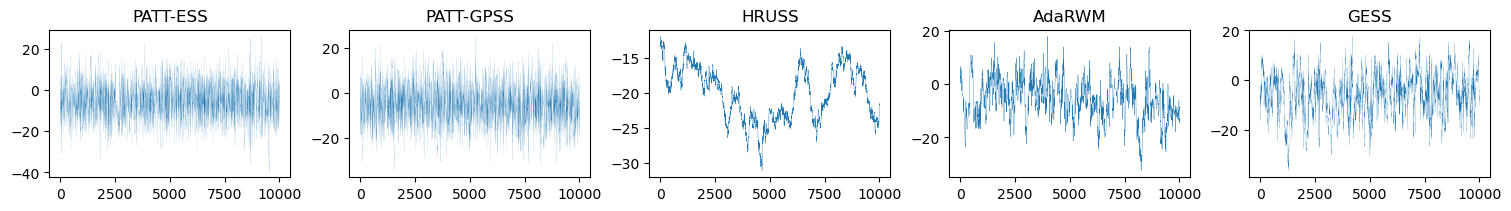

In [29]:
lws = [0.05, 0.05, 0.25, 0.25, 0.1]
path = path_prefix + "marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in samples], snames, filepath=path, lws=lws)

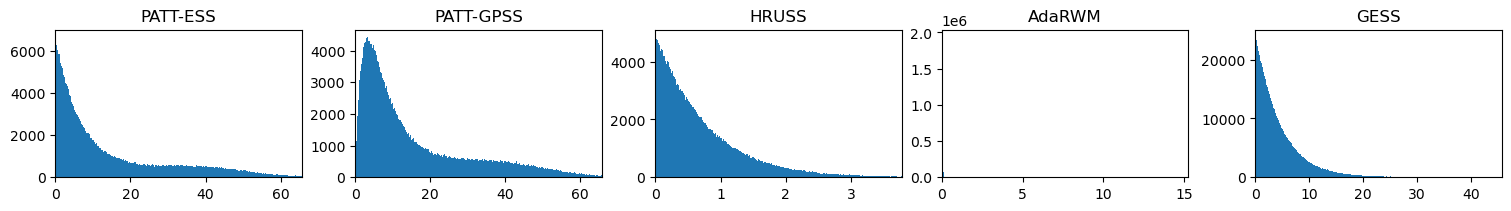

In [30]:
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[2] = plot_steps[2][plot_steps[2] != 0.0]
path = path_prefix + "steps.png"
pfs.plot_step_hist_row(plot_steps, snames, filepath=path)

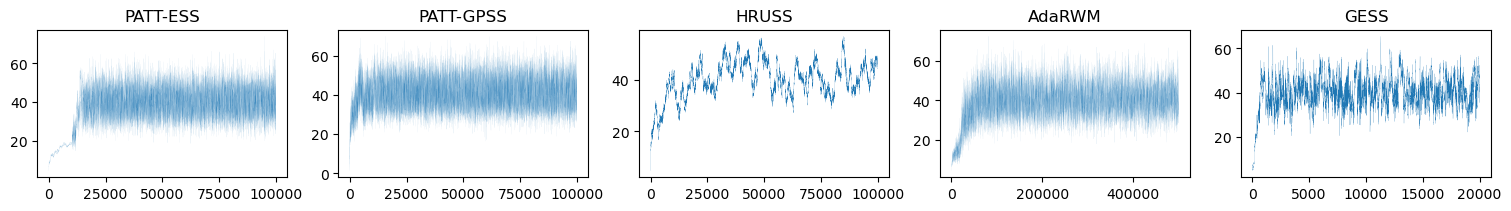

In [31]:
lws = [0.025, 0.025, 0.1, 0.025, 0.1]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

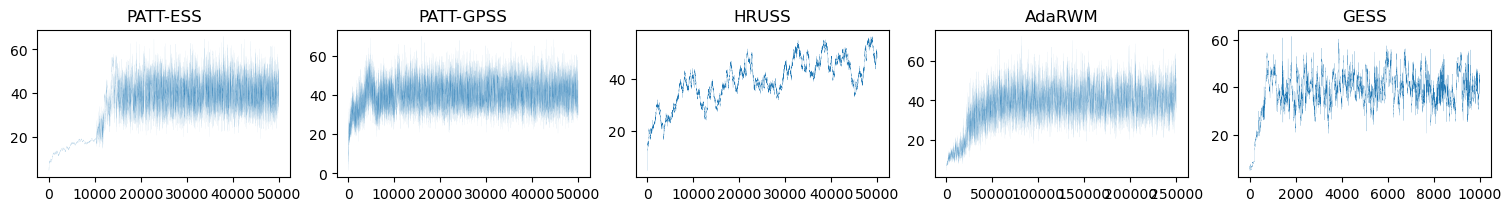

In [32]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

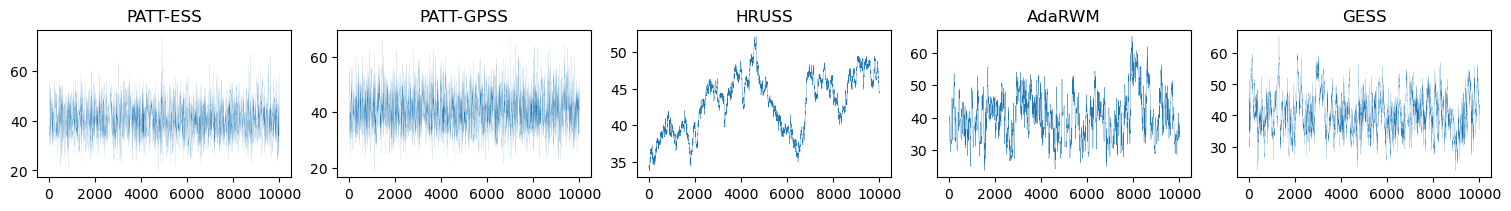

In [33]:
lws = [0.05, 0.05, 0.25, 0.25, 0.1]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

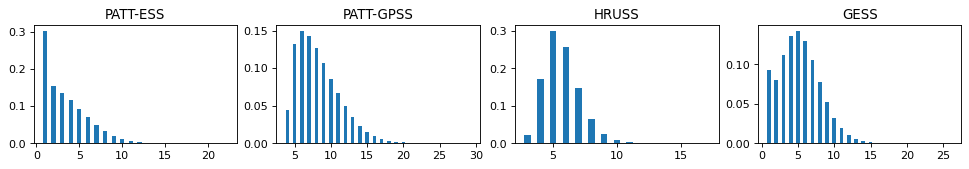

In [34]:
no_rwm = [0,1,2,4]
pfs.plot_tde_distr_row([tde[i] for i in no_rwm], [snames[i] for i in no_rwm])

In [35]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.223
Minimal AdaRWM acceptance rate: 0.221
Maximal AdaRWM acceptance rate: 0.227


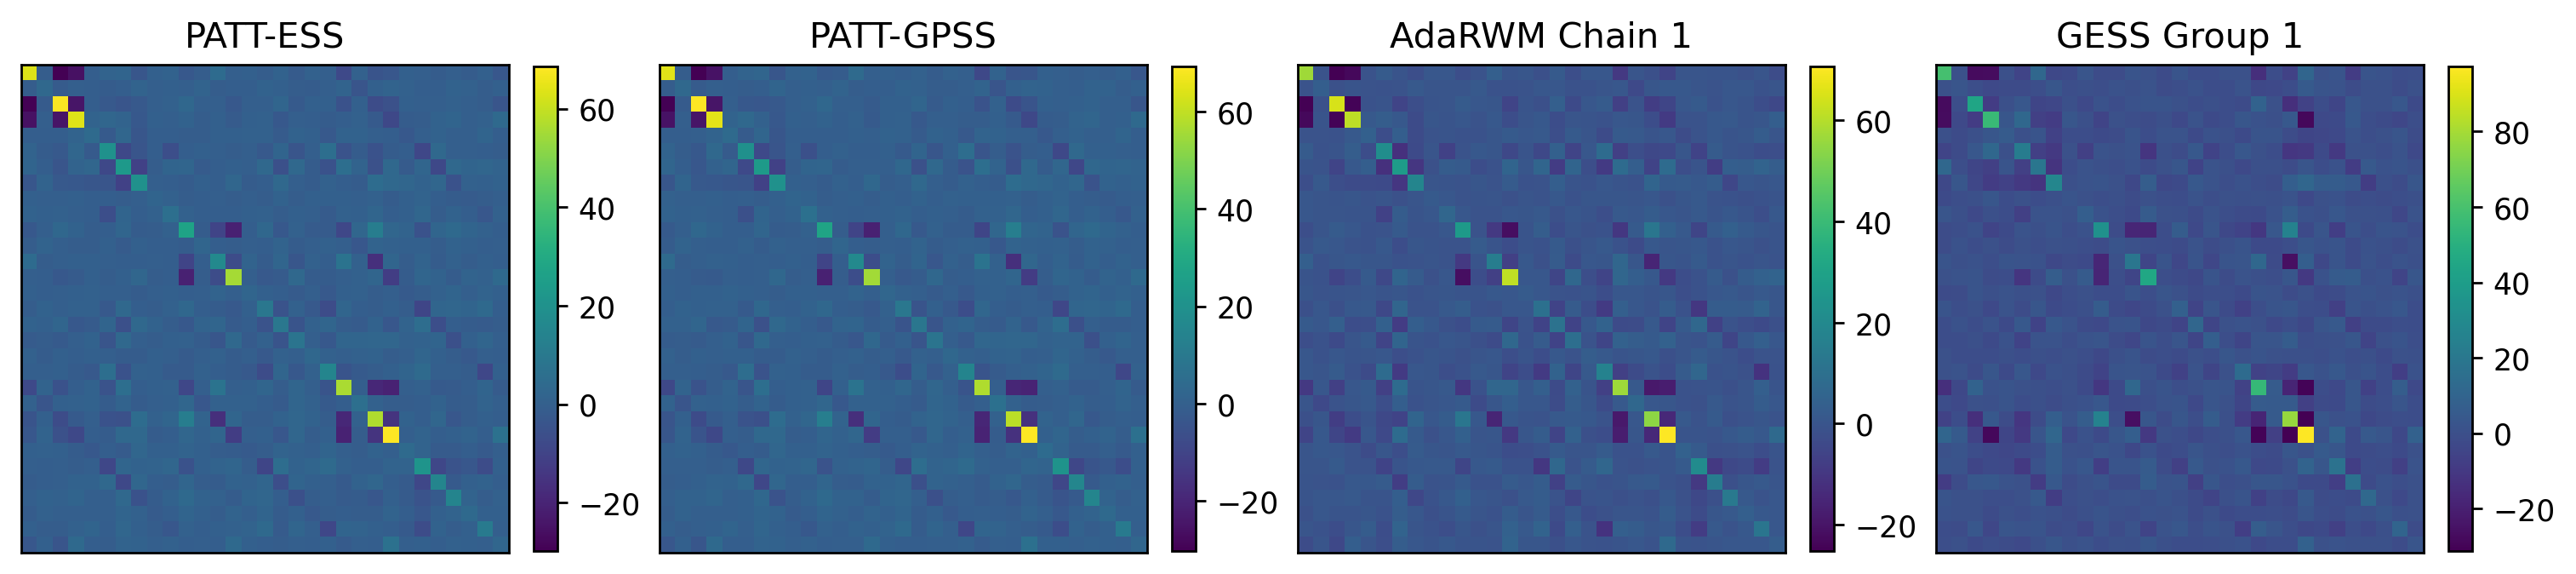

In [36]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "GESS Group 1"]
covs = [covs_ess[-1], covs_gpss[-1], cov_rwm[0], scale_G1]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path, shrink=0.78)

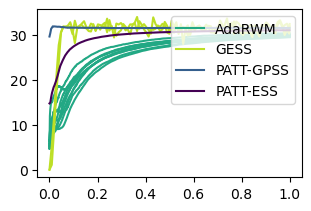

In [37]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
norms_rwm = mcu.get_radii(means_rwm)
norms_gess = mcu.get_radii(centers_gess)
colors = plt.cm.viridis(np.linspace(0, 0.9, 4))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,0], color=colors[3], label=snames[4])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,1], color=colors[3])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

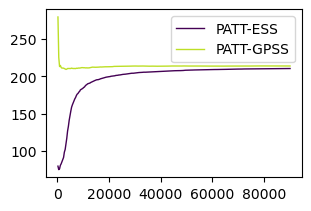

In [38]:
# plot progressions of the norm of the PATT samplers' posterior covariance approximations
cov_norms_ess = mcu.get_radii(covs_ess.reshape(schedule_ess.shape[0],-1))
cov_norms_gpss = mcu.get_radii(covs_gpss.reshape(schedule_gpss.shape[0],-1))
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], cov_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], cov_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

In [39]:
# I would plot the dfs used by GESS, but...
print(np.unique(dfs_G1[1:]))
print(np.unique(dfs_G2[1:]))

[1000000.]
[1000000.]


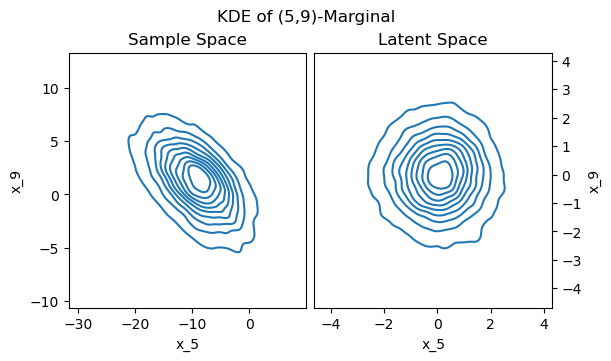

In [40]:
# plot a bivariate marginal KDE in sample space and (PATT-ESS's final) latent space
inds = [5,9]
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[0][:,0,inds[0]].reshape(-1,1),
                                samples[0][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
L = np.linalg.cholesky(covs_gpss[-1])
L_inv = np.linalg.inv(L)
alpha_inv = lambda y: L_inv @ (y - means_gpss[-1])
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[0][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

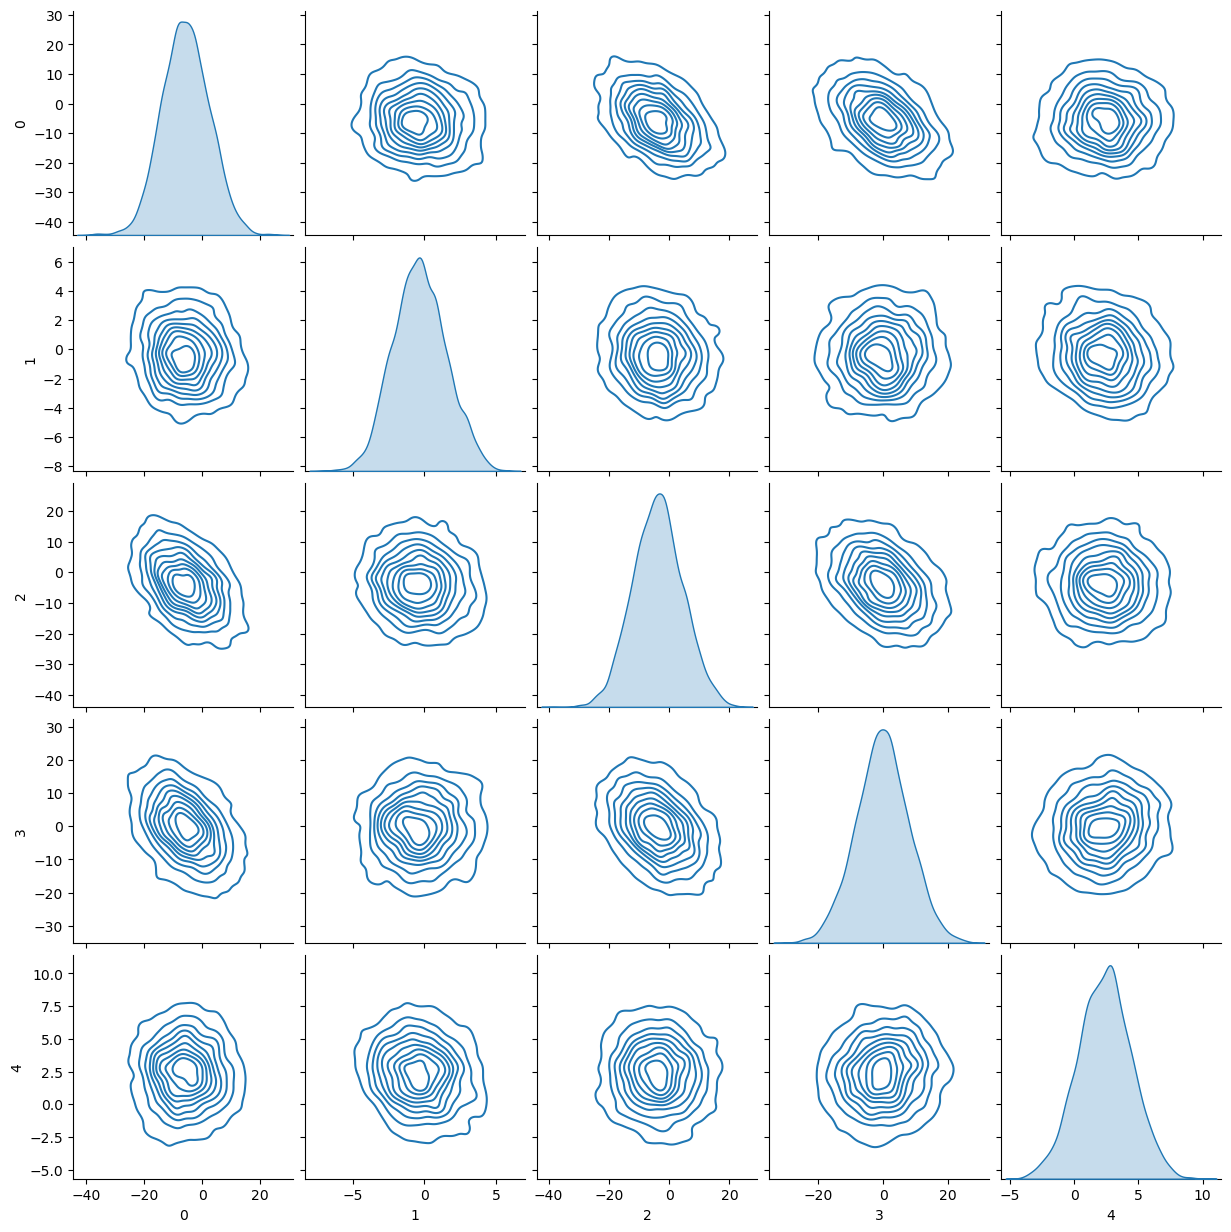

In [41]:
# this cell may take a few minutes to run
sb.pairplot(pd.DataFrame(samples[0][-n_win:,0,:5]), kind='kde')
plt.show()

In [42]:
pos_mean_ests[0]

array([-5.17884008, -0.35032289, -4.13152524, -0.2626781 ,  2.43838288,
       -9.45432653,  9.157966  ,  4.34043039, -1.57920431,  1.26961268,
        6.21731402, -2.60678461, -3.17937501, 11.68089137,  1.86798948,
        4.03301721, -7.04748084,  6.38964388, -2.04035054, -9.43930672,
        7.79377272,  6.66955758,  5.16617479, 10.43915793, -0.7994279 ,
       -4.06166747,  4.48870705,  1.87885045,  4.1536519 ,  6.52561373,
        3.28592244])